<div style="text-align: center">
    <h1 style="font-size: 54px;"><strong>Deep learning for EEG-based human emotion recognition:</strong></h1>
</div>
<div style="text-align: center">
    <h3 h1 style="font-size: 40px;"><strong>4-class CNN classifier based on valence-arousal quadrants (DEAP Dataset)</strong></h3>
</div>

# **Table of contents**

# **1. Project overview**

# **2. Imports**

Let's first import all the necessary packages and libraries.


In [49]:
import gdown
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import spectrogram

# **3. Loading and previewing EEG data**

## **3.1. Data exploration**

In [3]:
file_id = '1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'data_preprocessed_python/s01.dat', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu
To: c:\dev\EEG_emotion_recognition\data_preprocessed_python\s01.dat
100%|██████████| 103M/103M [02:35<00:00, 664kB/s]  


'data_preprocessed_python/s01.dat'

We load EEG data for subject 1 from the DEAP dataset using Python’s pickle module. The `'rb'` flag opens the file in binary read mode, and `'latin1'` encoding ensures compatibility with the original format.

In [4]:
with open('data_preprocessed_python/s01.dat', 'rb') as file:    
    subject_data = pickle.load(file, encoding='latin1')

In [5]:
type(subject_data)

dict

In [6]:
print(subject_data.keys())

dict_keys(['labels', 'data'])


In [41]:
subject_eeg_data = subject_data['data']
subject_labels = subject_data['labels']

print(subject_eeg_data.shape)
print(subject_labels.shape)

(40, 40, 8064)
(40, 4)


The dataset is a Python dictionary containing two keys: `labels` and `data`.

`subject_data['data']` is an array of shape **40 x 40 x 8064** representing EEG and EOG data from 40 signal channels (32 EEG + 8 EOG). Each channel was sampled at 128 Hz over 60-second trials, resulting in 8064 time samples per trial. A total of 40 trials were recorded for this subject while watching 40 different videos.

`subject_data['labels']` is an array of shape **40 x 4**, where each row corresponds to a trial (one video) and contains subjective emotional ratings given by the participant. The four dimensions are:

- **valence** (*column 0*), 
- **arousal** (*column 1*), 
- **dominance** (*column 2*), and 
- **liking** (*column 3*). 

Emotional ratings were given on a **continuous scale from 1 to 9**, where higher values represent more positive valence, higher arousal, dominance, and liking.

*(See the samples of the data below)*

In [42]:
print(subject_eeg_data[0])

[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
  -4.47722969e+00 -3.67692812e+00]
 [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
  -6.28780884e+00 -4.47429041e+00]
 [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
  -7.40651010e+00 -6.75590441e+00]
 ...
 [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
   1.28312149e+03  1.51996480e+03]
 [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
  -1.57823160e+04 -1.57808512e+04]
 [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
  -9.76081241e-02 -9.76081241e-02]]


In [43]:
df_labels = pd.DataFrame(
    subject_labels, 
    columns=['valence', 'arousal', 'dominance', 'liking']
)

df_labels.head(10)

,valence,arousal,dominance,liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


## **3.2. Data visualization**

First, we will look at the raw signal recorded during the first movie presentation. The plot below shows the record of the **first 5 seconds (640 samples)**.

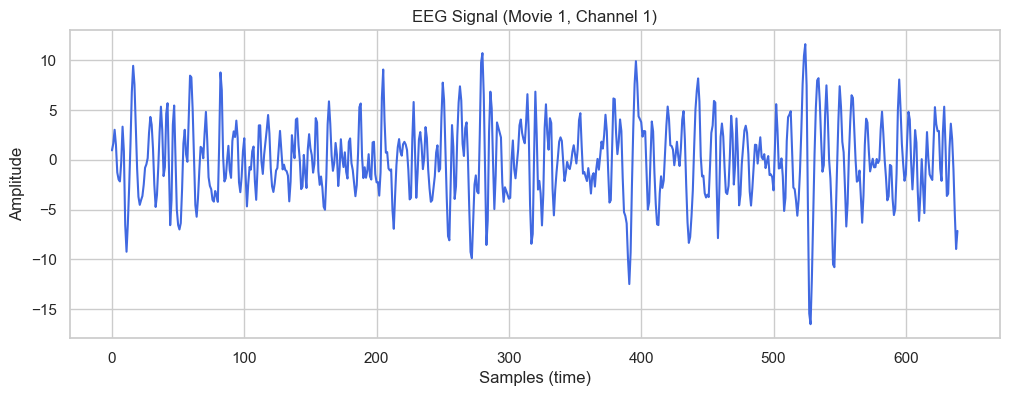

In [75]:
video_index = 0
channel_index = 0

sample_signal = subject_eeg_data[video_index, channel_index, 0:640]

plt.figure(figsize=(12, 4))
plt.plot(sample_signal, color='royalblue') 
plt.title(f'EEG Signal (Movie {video_index + 1}, Channel {channel_index + 1})')
plt.xlabel('Samples (time)')
plt.ylabel('Amplitude')

plt.show()


The EEG signal shown above — already preprocessed to remove common artifacts such as eye blinks — reflects clean neural activity patterns suitable for further transformation into **frequency-domain features**. These features will later serve as input for a **convolutional neural network (CNN)** model in our emotion classification task.

To better understand the temporal dynamics of these frequency components, using `SciPy` library we compute a **spectrogram** of the signal recorded during the first movie presentation from the first channel. Spectrograms allow us to visualize **how the power of various frequency bands evolves over time**, which is particularly important in EEG-based emotion recognition — since distinct emotional states are often linked to specific oscillatory patterns in the brain (e.g., **Alpha (8-13 Hz)** suppression during heightened arousal, or increased **Theta (4-8 Hz)** activity during calmness or introspection).

*Note:*
*Due to the use of sliding windows with overlap in spectrogram computation* `(nperseg=128, noverlap=64)`*, the resulting time axis starts slightly after 0 seconds and ends before 5 seconds. This ensures that each time window contains a complete set of samples needed for the Fourier transform.*


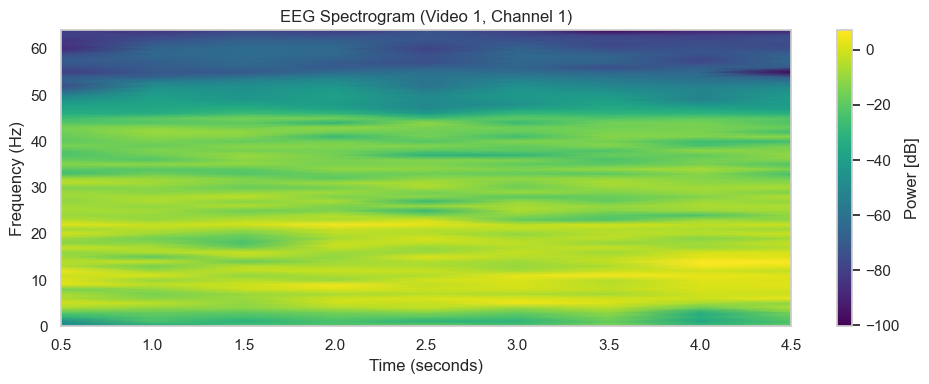

In [76]:
sampling_frequency = 128
frequencies, times, spec_power = spectrogram(sample_signal, fs=sampling_frequency, nperseg=128, noverlap=64)

plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(spec_power), shading='gouraud', cmap='viridis')
plt.title(f'EEG Spectrogram (Video {video_index + 1}, Channel {channel_index + 1})')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()